# Picks the sample for the IGRINS proposal.
Michael Gully-Santiago  
January-February 2016

### <i class="fa fa-arrow-right fa-1x"></i>   Input:

<i class="fa fa-table fa-2x"></i> 1658 <i class="fa fa-times fa-1x"></i> 60  
<i class="fa fa-file-text fa-2x"></i>
`../analysis/K2C02_YSO_sim_WISE.csv`  

### Output <i class="fa fa-arrow-right fa-1x"></i>   :

<i class="fa fa-list fa-2x"></i> Target list  
<i class="fa fa-bar-chart fa-2x"></i> `K2_selection.pdf`

In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina' 
import warnings

### Read in the K2c02 data crossmatched with kplr

In [2]:
k2_simbad = pd.read_csv('../analysis/K2C02_YSO_sim_WISE.csv')
k2_cln_simbad = pd.read_csv('../analysis/K2C02_YSO_CLN_match.csv')

Use the cleaned dataset, but make sure we have WISE data available.

In [3]:
xtra_cols = ['EPIC_ID', 'AllWISE', 'W1mag', 'e_W1mag', 'W2mag', 'e_W2mag', 'W3mag',
       'e_W3mag', 'W4mag', 'e_W4mag']
k2_c2 = pd.merge(k2_cln_simbad, k2_simbad[xtra_cols], how='outer', on=['EPIC_ID'])

In [4]:
candidates = ['203516237', '203642381', '203731383', '203793391', '203826403',
       '203801323', '203810698']

# Selection criteria

Main goals:
1. Observable
2. Has sunspots
3. No disk

Selection criteria:
1. H < 10.5
2. K < 10.5
3. Above average level of activity
4. Periodic variability (i.e., not purely stochastic)
5. M or K spectral type
6. Oph or Upper sco.
7. Previously identified as T-Tauri star

In [5]:
from bokeh.io import output_notebook
output_notebook()
from bokeh.plotting import figure, show, output_file, vplot

Loading BokehJS ...

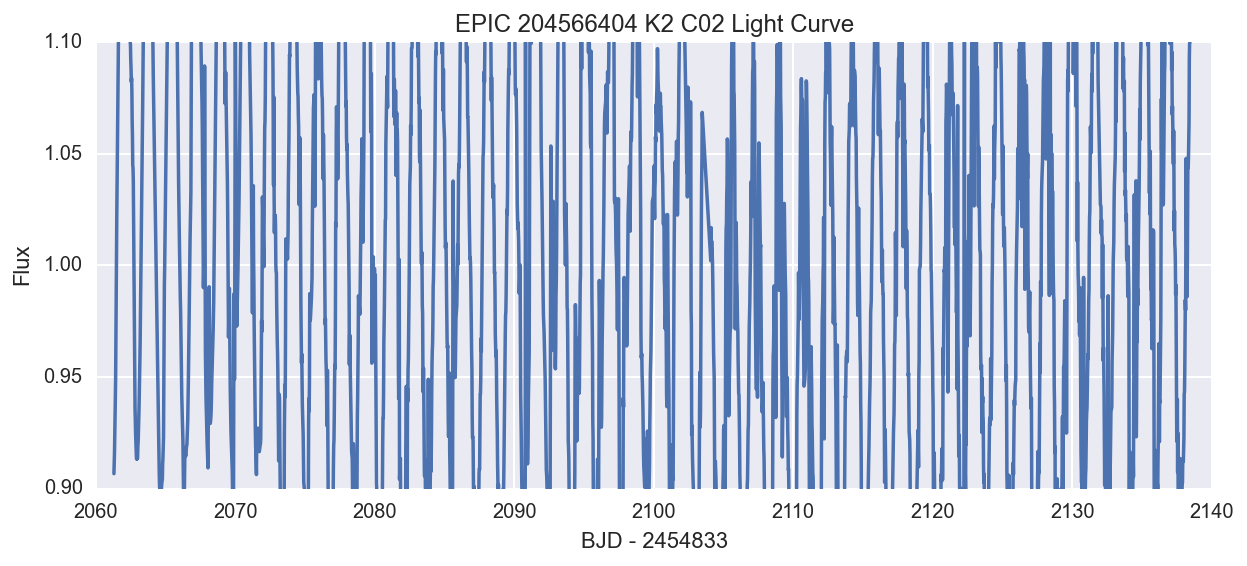

In [6]:
this_cand = 204566404

ii = k2_c2.index[k2_c2.EPIC_ID == this_cand].values[0]

plt.figure(figsize=(10, 4))
file = k2_c2.fname[ii]
raw_lc = pd.read_csv(file, index_col=False)

plt.plot(raw_lc['BJD - 2454833'], raw_lc[' Corrected Flux'])
plt.ylim(0.9, 1.1)
#plt.ylim(0.99, 1.01)
#plt.ylim(0.8, 1.2)
plt.title("EPIC {} K2 C02 Light Curve".format(k2_c2.EPIC_ID[ii]))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

In [7]:
k2_c2.OTYPE.unique()

array([nan, 'Star', 'RotV*', 'Candidate_YSO', 'X', 'TTau*', 'pMS*',
       '*inAssoc', 'brownD*', '**', 'RGB*', 'PulsV*delSct', '*inCl',
       'Orion_V*', 'Ae*', 'Em*', 'IR', 'Flare*', 'YSO', 'AGB*',
       'Candidate_brownD*', 'Candidate_TTau*', 'RotV*alf2CVn', 'BYDra',
       'V*', 'RSCVn', 'EB*Algol', 'Cepheid', 'SB*'], dtype=object)

In [8]:
vs = k2_c2.OTYPE == 'TTau*'
vs.sum()

118

In [9]:
temp = k2_c2.EPIC_ID[vs]

In [10]:
#temp.to_csv('../analysis/K2_P_estimates.csv', index=False)

In [11]:
k2_c2.EPIC_ID.head()

0    202515599
1    202521690
2    202533810
3    202539362
4    202544694
Name: EPIC_ID, dtype: int64

In [12]:
this_cand = 202539362

ii = k2_c2.index[k2_c2.EPIC_ID == this_cand].values[0]

file = k2_c2.fname[ii]
raw_lc = pd.read_csv(file, index_col=False)

p1 = figure()
p1.plot_width=700
p1.plot_height=400
p1.grid.grid_line_alpha=0.3
p1.xaxis.axis_label = 'BJD - 2454833'
p1.yaxis.axis_label = 'Corrected Flux'

p1.line(raw_lc['BJD - 2454833'], raw_lc[' Corrected Flux'], color='#EF0E03')

show(p1)  # open a browser

# Periods

In [13]:
from astroML.time_series import multiterm_periodogram
from astroML.time_series import lomb_scargle

//anaconda/lib/python3.4/site-packages/astroML/time_series/periodogram.py:8: UserWarning: Using slow version of lomb_scargle. Install astroML_addons to use an optimized version
  warnings.warn("Using slow version of lomb_scargle. Install astroML_addons "


In [14]:
x_full = raw_lc['BJD - 2454833'].values
y_full = raw_lc[' Corrected Flux'].values

gi = (x_full > 2065) & (x_full < 2095)

x, y = x_full[gi], y_full[gi]

yerr = y*0.001

In [15]:
periods = np.linspace(0.1, 7.0, 10000)

omega = 2.00*np.pi/periods

P_M = multiterm_periodogram(x, y, yerr, omega)
P_LS = lomb_scargle(x, y, yerr, omega)

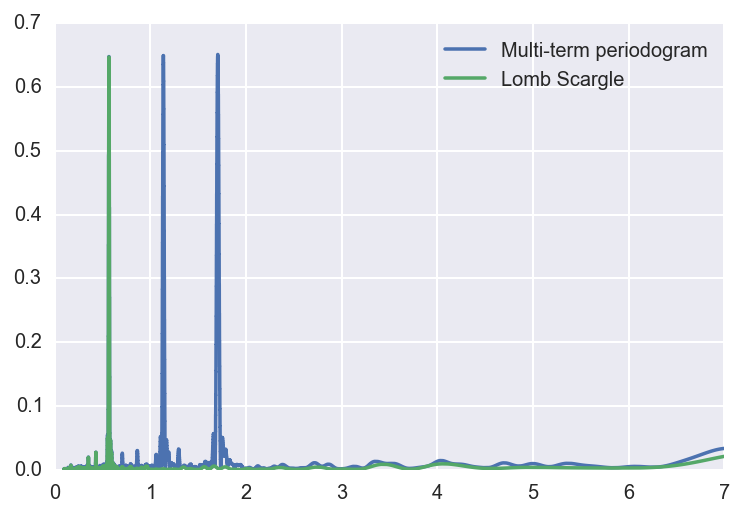

In [16]:
plt.step(periods, P_M, label='Multi-term periodogram')
plt.step(periods, P_LS, label='Lomb Scargle')
plt.legend()

In [41]:
P_coarse_fit = periods[np.argmax(P_LS)]

In [42]:
periods = np.linspace(P_coarse_fit*0.8, P_coarse_fit*1.2, 10000)

omega = 2.00*np.pi/periods

P_M = multiterm_periodogram(x, y, yerr, omega)
P_LS = lomb_scargle(x, y, yerr, omega)

In [43]:
P_fit = periods[np.argmax(P_LS)]

In [44]:
P_fit

0.56881841799541488

# Linear regression example

$y = c_0 + c_1 \cdot x + c_2 \cdot \sin{\frac{2\pi x}{P}} + c_3 \cdot \cos{\frac{2\pi x}{P}} $

We have four coefficients: $c_1, c_2, c_3, c_4$

In [45]:
sin_vector = np.sin(2.0*np.pi*x/P_fit)
cos_vector = np.cos(2.0*np.pi*x/P_fit)

In [60]:
A = np.concatenate((np.expand_dims(cos_vector, 1),
                    np.expand_dims(sin_vector, 1),
                    np.vander(x, 1)), axis=1)

In [61]:
ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

In [62]:
yfit = np.matmul(mean_w, A.T)

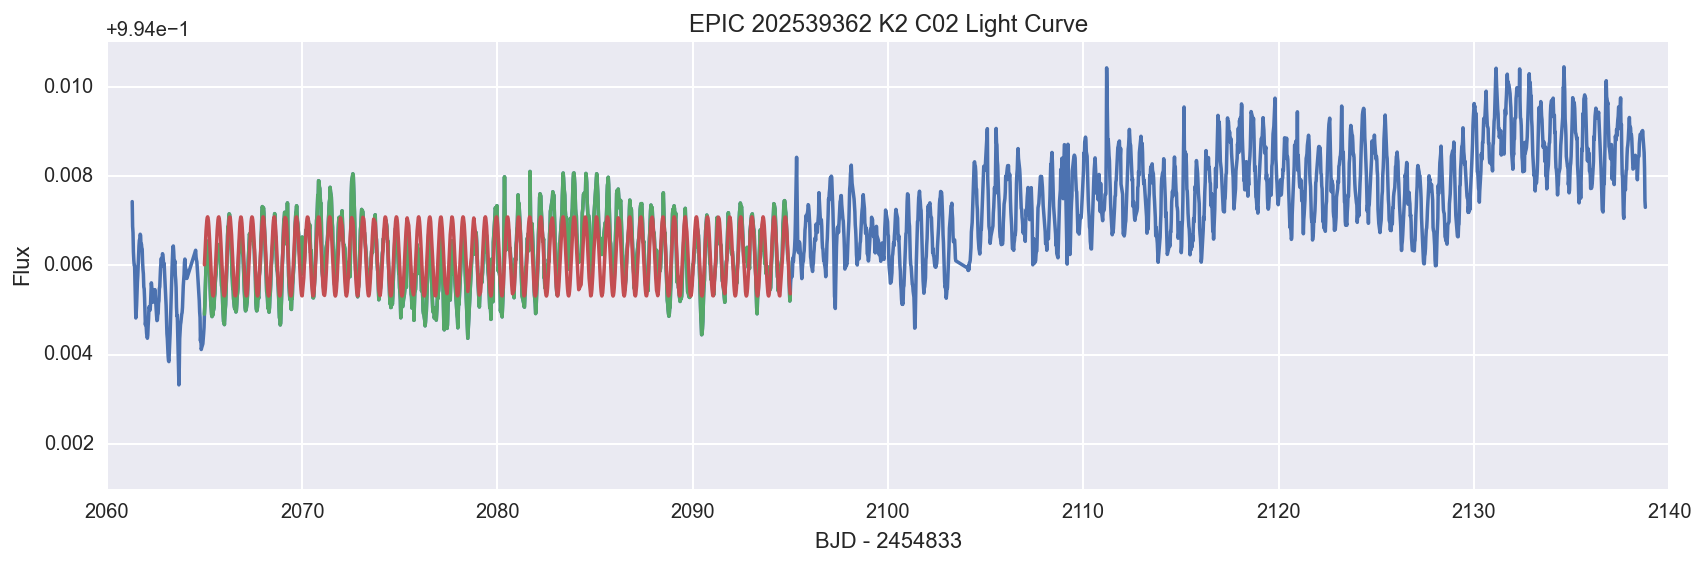

In [63]:
this_cand = 202539362

ii = k2_c2.index[k2_c2.EPIC_ID == this_cand].values[0]

plt.figure(figsize=(14, 4))
file = k2_c2.fname[ii]
raw_lc = pd.read_csv(file, index_col=False)

plt.plot(raw_lc['BJD - 2454833'], raw_lc[' Corrected Flux'])

plt.plot(x, y)
plt.plot(x, yfit)

#plt.ylim(0.95, 1.005)
plt.ylim(0.995, 1.005)
plt.title("EPIC {} K2 C02 Light Curve".format(k2_c2.EPIC_ID[ii]))
plt.xlabel('BJD - 2454833')
plt.ylabel('Flux');

In [52]:
from sklearn import cross_validation

In [65]:
def lin_regress(A, y, yerr):
    ATA = np.dot(A.T, A / yerr[:, None]**2)
    sigma_w = np.linalg.inv(ATA)
    mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))
    return mean_w

In [66]:
polys = np.arange(1, 50)
net_scores = np.zeros(len(polys))
n_folds = 10

In [67]:
j = 0
for n_poly in polys:

    X = np.concatenate((np.expand_dims(cos_vector, 1),
                        np.expand_dims(sin_vector, 1),
                        np.vander(x, n_poly)), axis=1)
    n, n_dim = X.shape
    scores_test = np.zeros(n_folds)

    kf = cross_validation.KFold(n, n_folds=n_folds)
    i = 0
    for train_index, test_index in kf:
        #print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_train_err, y_test_err = yerr[train_index], yerr[test_index]
        w_train = lin_regress(X_train, y_train, y_train_err)
        y_test_fit = np.matmul(w_train, X_test.T)
        resid = np.sqrt(np.sum(((y_test-y_test_fit)/y_test_err)**2))
        scores_test[i] = resid
        i += 1
    net_scores[j] = np.mean(scores_test)
    j += 1

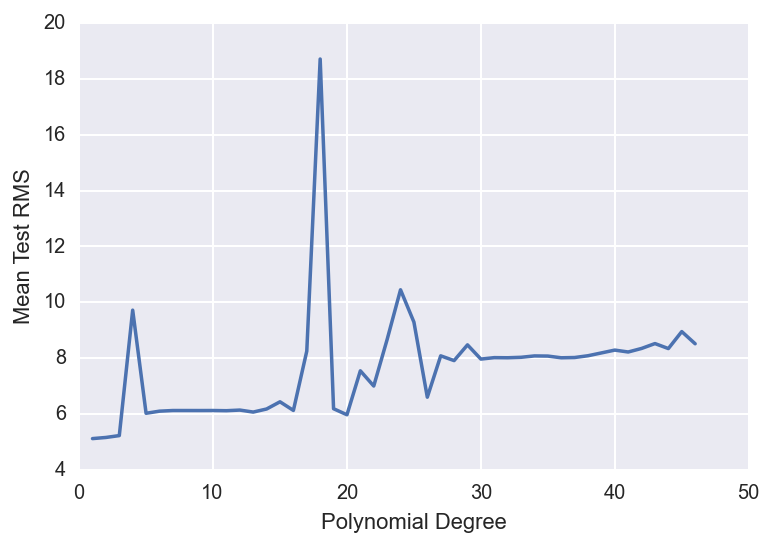

In [68]:
plt.plot(polys, net_scores)
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Test RMS')

## Determine the amplitudes

In [32]:
opt_poly = polys[np.argmin(net_scores)]

4

In [33]:
A = np.concatenate((np.expand_dims(cos_vector, 1),
                    np.expand_dims(sin_vector, 1),
                    np.vander(x, opt_poly)), axis=1)

In [34]:
ATA = np.dot(A.T, A / yerr[:, None]**2)
sigma_w = np.linalg.inv(ATA)
mean_w = np.linalg.solve(ATA, np.dot(A.T, y/yerr**2))

In [41]:
#sns.heatmap(np.log10(sigma_w), annot=True)

In [35]:
mean_w

array([ -9.60454334e-03,   1.86361236e-02,  -7.84097253e-06,
         4.89469845e-02,  -1.01848993e+02,   7.06428927e+04])

In [45]:
n_dim, = mean_w.shape

The first two are A and B.

In [51]:
np.sqrt(mean_w[0]**2 + mean_w[1]**2)

0.020965503960862358

The end for now.